# Merton's Jump Diffusion Model (1976)

In [82]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(palette='viridis')
%matplotlib inline
%config InlineBackend.figure_format='retina'

## Overview

A jump diffusion model is a mixture model combining a diffusion process with a jump process (Figure 1). In finance, jump diffusion models were introduced by Merton [1], who interpreted jumps as "idiosyncratic shocks affecting individual companies but not the market as a whole."

#### Figure 1: Sample path of a jump diffusion process.

![Sample path of a jump diffusion process.](https://nbviewer.jupyter.org/github/federicomariamassari/financial-engineering/blob/master/handbook/img/sample-path-jdm.png)

## Stochastic Differential Equation

Merton's model specifies the following SDE for the risky asset [2]:

<br>

<center>
    $\dfrac{dS(t)}{S(t-)} = \mu dt + \sigma dW(t) + dJ(t)$
</center>

<br>

* $S(t-)$ = the value of the stock price right before a potential jump, i.e. $S(t-) := lim_{x\rightarrow t-} S(x)$
* $\mu$, $\sigma$ = constant drift and volaility
* $W$ = a one-dimensional standard Wiener process in $[0, T]$
* $J$ = a jump process, indepedent of $W$, with piecewise constant sample paths

## The Jump Component

In Merton's model, $J(t)$ is a compound Poisson process defined by:

<br>
<center>
    $J(t) := \sum_{j=1}^{N(t)} (Y_{j} - 1)$
</center>
<br>

* $N(t) \sim$ Poisson$(\lambda t)$ is a counting process representing the total number of jumps which have occurred up to a certain arrival date $t$
* $Y(t)$ is a sequence of multiplicative jumps, i.i.d. random variables (independent of both $N$ and $Y$), with $Y_{j} = \dfrac{S(\tau_{j})}{S(\tau_{j}-)} \forall j\in\mathbb{Z}\cap[1, N(t)]$ and $Y_{j} - 1$, so that $Y_{j} - 1 = 1 - 1 = 0$.

## Solution to the SDE

The solution is given by:

<br>
<center>
    $S(t) = S_{0} exp \{(\mu - \dfrac{1}{2}\sigma^{2})t + \sigma W(t)\}(\prod_{j=1}^{N(t)}Y_{j})$
</center>
<br>

When $\prod_{j=1}^{N(t)}Y_{j} = 1$, indicating an absence of jumps, the equation is also the solution the geometric Brownian motion SDE.

## Discretisation and Monte Carlo

Discretisation of the solution to the SDE allows us to simulate the model using a Monte Carlo. The goal of the simulation is to ontain estimates of the expected value and variance for $S(T)$, which is the stock price at maturity.

The probability that the theoretical mea is included in the confidence interval calculated with the Monte Carlo estimates is expected to converge to $1$ as the confidence parameter $\alpha$ decreases, and as the number of experiments grows.

The time interval $[0, T]$ can be sub-divided into $N + 1$ equally-spaced integer monitoring dates $t_{j}$. with $t_{0} = 0$, $t_{N} = T$ and:

<br>
<center>
    $t_{j} := \dfrac{jT}{N} \forall j\in\mathbb{Z}\cap[0, N]$
</center>
<br>

The difference $t_{j+1}-t_{j}$ is constant and equal to:

<br>
<center>
    $\delta t := t_{j+1} - t_{j} = \dfrac{T}{N} \forall j\in\mathbb{Z}\cap[1, N]$
</center>
<br>

A discretized version of the solution to Merton's SDE is then given by the following three formulae:

<br>
<center>
    $S(t_{j+1}) = S(t_{j}) exp \{(\mu - \dfrac{1}{2}\sigma^2)\Delta t + \sigma Z_{1}\sqrt{\Delta t} + J\}, Z_{1}\sim N(0, 1), \forall t \in[0, T]$
    <br>
    $J = \mu_{Y}N(\Delta t) + \sigma_{Y}Z_{2}\sqrt{N(\Delta t)}, Z_{2}\sim N(0, 1)$
    <br>
    $N(\Delta t)\sim \text{Poisson}(\lambda\Delta t)$
</center>
<br>

* $Z_{1}, Z_{2}$ = two standard Gaussian random variables independent of each other
* $Z\bullet\sqrt{\Delta t}$ = a discretised version of the standard Wiener motion $W(t)$
* $\mu_{Y}, \sigma_{Y}$ = the mean and standard deviation of the multiplicative jumps, defined by:

<br>
<center>
    $\mu_{Y} = \mathbb{E}[Y_{j}] = exp \{a + \dfrac{1}{2}b^{2}\}$
    <br>
    $\sigma_{Y}^2 = V[Y_{j}] = exp \{2a + b^2\}(exp \{b^2\} - 1)$
    <br>
    $a, b \ni ln(Y_{j})\sim N(a, b^{2})$
<br>

## Theoretical Moments

Closed formulae exist for the expected value and variance at maturity of an asset following Merton's SDE. Under the physical probability measure $\mathbb{P}$:

<br>
<center>
    $M = \mathbb{E}^{\mathbb{P}}[S(T)] = S(0) exp \{\mu T + \lambda T(\mathbb{E}[Y_{j}] - 1)\}$
</center>
<br>
<center>
    $V = V^{\mathbb{P}}[S(T)] = S^{2}(0)(exp\{(2\mu + \sigma^{2})T + \lambda T(\mathbb{E}[Y_{j}^{2}] - 1)\} - exp\{2\mu T + 2\lambda T(\mathbb{E}[Y_{j}] - 1)\})$
</center>
<br>

These exact values can be used to monitor the rate of convergence of Monte Carlo estimates as the number of simulated experiments increases, and can help spot errors, if any, in implementing the model.

## Set Random Seed

We will need to set the random seed to reproduce the results in a deterministic fashion.

In [83]:
np.random.seed(0)

## Define Parameter Values

`S` = initial price of the risky asset, or $S_{0}$ \
`X` = strike price \
`T` = maturity of the derivative contract \
`mu`, `sigma` = the mean and standard deviation of the stock price process \
`Lambda` = the intensity of the Poisson process (lambda is a protected keyword in Python) \
`a`, `b` = parameters useful to determine $\mu_{Y}$ and $\sigma_{Y}^{2}$ \
`Nsteps` = the number of monitoring dates \
`Nsim` = the number of simulated experiments \
`alpha`: significance level required to compute confidence intervals

In [84]:
S = 1
X = 1.05
T = 1
mu = 0.12
sigma = 0.3
Lambda = 0.25
a = 0.2
b = 0.2
Nsteps = 252
Nsim = 100
alpha = 0.05

## Define Auxiliary Parameters:

$\Delta t = \dfrac{T}{NSteps}$

In [85]:
# Calculate delta t.
delta_t = T/Nsteps

print('Delta t = {:.6f}'.format(Delta_t))

Delta t = 0.003968


In [86]:
# Calculate lognormal mean and variance.
mean_Y = np.exp(a + 0.5*(b**2))
variance_Y = np.exp(2*a + b**2) * (np.exp(b**2)-1)

print('Lognormal mean = {:.6f}'.format(mean_Y))
print('Lognormal variance = {:.6f}'.format(variance_Y))

Lognormal mean = 1.246077
Lognormal variance = 0.063367


In [87]:
# Calculate theoretical mean and variance of the risky asset under Merton's model.
M = S * np.exp(mu*T + Lambda*T*(mean_Y-1))
V = S**2 * (np.exp((2*mu + sigma**2)*T + Lambda*T*(variance_Y + mean_Y**2 - 1)) - np.exp(2*mu*T + 2*Lambda*T*(mean_Y - 1)))

print('Theoretical mean = {:.6f}'.format(M))
print('Theoretical variance = {:.6f}'.format(V))

Theoretical mean = 1.199038
Theoretical variance = 0.184891


## Pre-allocate Memory for the Monte Carlo

We will now pre-allocate memory for the Monte Carlo by generating a `Nsim` x (`Nsteps` + 1) array of zeroes and populate the first column with the initial asset price.

In [88]:
simulated_paths = np.zeros([Nsim, Nsteps + 1])
simulated_paths[:, 0] = S

print('Size of a single array element: {} bytes'.format(simulated_paths.itemsize))
print('Total memory requirement: {:.2f} kilobytes'.format(simulated_paths.nbytes / 2**10))

Size of a single array element: 8 bytes
Total memory requirement: 197.66 kilobytes


## Generate Sources of Randomness

We will now generate the sources of randomness for the simulation:

* Arrays of i.i.d. standard Gaussian random variables $Z_{1}\sim N(0, 1)$ and $Z_{2}\sim N(0, 1)$, independent of each other
* $N(\Delta t)\sim\text{Poisson}(\lambda\Delta t)$

Jumps will occur whenever a cell in `Poisson` is different from zero, and both the direction and magnitude of the jump will be dictated by the corresponding cell in `Z_2`.

In [89]:
Z_1 = np.random.normal(size=[Nsim, Nsteps])
Z_2 = np.random.normal(size=[Nsim, Nsteps])
Poisson = np.random.poisson(Lambda*Delta_t, [Nsim, Nsteps])

## Populate the Matrix

For each row, we recursively populate the remaining columns.

In [90]:
for i in range(Nsteps):
    simulated_paths[:,i+1] = simulated_paths[:,i]*np.exp((mu - sigma**2/2)*Delta_t \
                             + sigma*np.sqrt(Delta_t) * Z_1[:,i] + a*Poisson[:,i] \
                             + np.sqrt(b**2) * np.sqrt(Poisson[:,i]) * Z_2[:,i])

The populated matrix, where each row is a simulated full path for the asset price and each column is a collection of all possible prices at a single monitoring date, resembles:

In [91]:
np.set_printoptions(precision=4, suppress=True)
simulated_paths[:5,:]

array([[1.    , 1.0342, 1.0424, ..., 1.2518, 1.2645, 1.2512],
       [1.    , 1.003 , 0.9972, ..., 0.7351, 0.7507, 0.7477],
       [1.    , 0.9938, 0.9832, ..., 0.5269, 0.5269, 0.5353],
       [1.    , 1.0131, 0.9999, ..., 1.2275, 1.2405, 1.1989],
       [1.    , 0.9994, 1.0042, ..., 1.577 , 1.56  , 1.5473]])

## Calculate Monte Carlo for the Mean and Variance of $S(T)$

In [92]:
final_prices = simulated_paths[:,-1]
mean_jump = np.mean(final_prices)
var_jump = np.var(final_prices)

print('Estimate for sample mean of S(T) = {:.6f}'.format(mean_jump))
print('Estimate for sample variance of S(T) = {:.6f}'.format(var_jump))

Estimate for sample mean of S(T) = 1.219831
Estimate for sample variance of S(T) = 0.256918


## Compare Estimates with Theoretical Values

In [93]:
error_mean = (mean_jump-M) / M
error_variance = (var_jump-V) / V

print('Estimate error relative to the theoretical mean = {:.2f}%'.format(error_mean * 100))
print('Estimate error relative to the theoretical variance = {:.2f}%'.format(error_variance * 100))

Estimate error relative to the theoretical mean = 1.73%
Estimate error relative to the theoretical variance = 38.96%


Note that the sign and magnitude of the errors vary depending on both the number of simulations (a higher number leads to smaller errors) and the random seed.

## Compute Confidence Intervals for the Mean

In [94]:
std_jump = np.std(final_prices)

ci_low = mean_jump - std_jump/np.sqrt(Nsim)*stats.norm.ppf(1-0.5*alpha)
ci_high = mean_jump + std_jump/np.sqrt(Nsim)*stats.norm.ppf(1-0.5*alpha)

print('{:.0f}% confidence level for the mean: ({:.6f}; {:.6f})'.format((1-alpha)*100, ci_low, ci_high))

95% confidence level for the mean: (1.120487; 1.319176)


We can be sure that $(1−α)\%$ of the time, the computed confidence intervals will contain the true expected value of $S(T)$.

## Graphical Representation

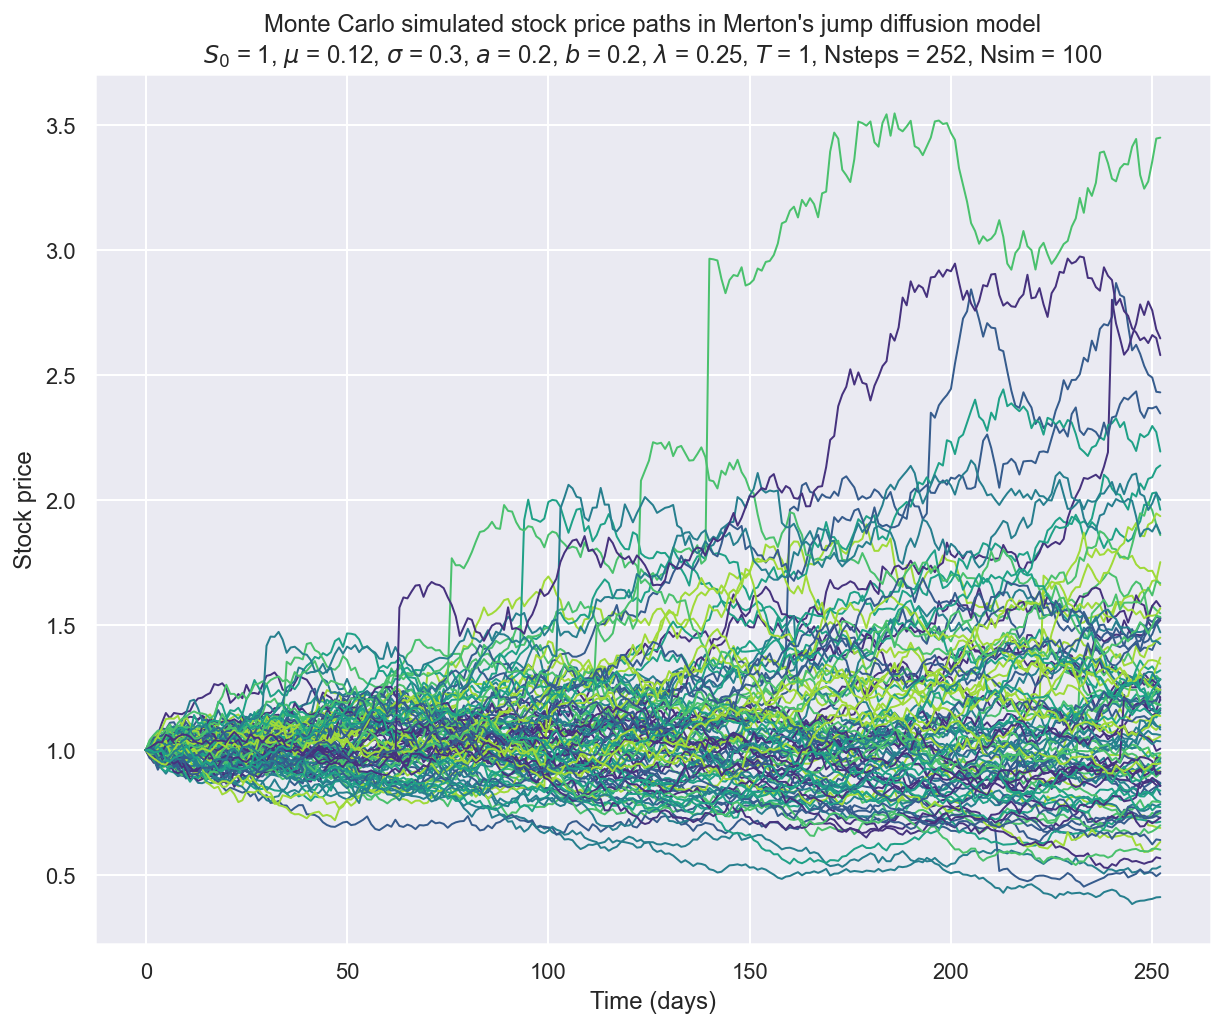

In [95]:
plt.figure(figsize=(10,8))
ax = plt.axes()

t = np.linspace(0, T, Nsteps+1) * Nsteps
jump_diffusion = ax.plot(t, simulated_paths.transpose());

plt.setp(jump_diffusion, linewidth=1);

ax.set(title="Monte Carlo simulated stock price paths in Merton's jump \
diffusion model\n$S_0$ = {}, $\mu$ = {}, $\sigma$ = {}, $a$ = {}, \
$b$ = {}, $\lambda$ = {}, $T$ = {}, Nsteps = {}, Nsim = {}"\
       .format(S, mu, sigma, a, b, Lambda, T, Nsteps, Nsim), \
       xlabel='Time (days)', ylabel='Stock price');

## Summary Report

In [98]:
# Compute skewness and excess kurtosis.
skew_jump = stats.skew(final_prices)
kurt_jump = stats.kurtosis(final_prices)

In [101]:
# Print statistics and align results.
print("Merton's Jump Diffusion Model")
print('-----------------------------')
print('Theoretical Moments')
print('-----------------------------')
print('Mean (M){:>21.4f}'.format(M))
print('Variance (V){:>17.4f}'.format(V))
print('\nMonte Carlo Estimates')
print('-----------------------------')
print('Mean {:>24.4f}'.format(mean_jump))
print('Variance {:>20.4f}'.format(var_jump))
print('Standard deviation {:>10.4f}'.format(std_jump))
print('Skewness {:>20.4f}'.format(skew_jump))
print('Excess kurtosis {:>13.4f}'.format(kurt_jump))
print('\nConfidence Interval, Mean')
print('-----------------------------')
print('Alpha {:>23.2f}'.format(alpha))
print('Lower bound {:>17.4f}'.format(ci_low))
print('Upper bound {:>17.4f}'.format(ci_high))

Merton's Jump Diffusion Model
-----------------------------
Theoretical Moments
-----------------------------
Mean (M)               1.1990
Variance (V)           0.1849

Monte Carlo Estimates
-----------------------------
Mean                   1.2198
Variance               0.2569
Standard deviation     0.5069
Skewness               1.5149
Excess kurtosis        3.2776

Confidence Interval, Mean
-----------------------------
Alpha                    0.05
Lower bound            1.1205
Upper bound            1.3192


## Bibliography

[1] Merton, R.C. (1976) _Option pricing when underlying stock returns are discontinuous_, Journal of Financial Economics, 3:125-144

[2] Glasserman, P. (2003) _Monte Carlo Methods in Financial Engineering_, Springer Applications of Mathematics, Vol. 53